## Use DiffNet to create FEP network plan based on ML PD predictions

In [1]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['figure.dpi']= 300

In [2]:
import networkx as nx
import numpy as np
from cvxopt import matrix
import diffnet as dn
import graph as gph
from netbfe import *
import csv
import matplotlib.image as mpimg
from numpy.lib.stride_tricks import as_strided

### Load numpy matrices for Loeffler18 set

In [3]:
sij = np.sqrt(np.load("TESTSETS/loeffler18/work/output/sij_sym.npy"))


In [4]:
# load ligand images + the order they appear in sij:
path_to_ligand_imgs = "TESTSETS/loeffler18/work/mol_imgs/"
path_to_ligand_idx = "TESTSETS/loeffler18/work/mol_imgs/ligand_index.csv"

ligand_order = []
with open(path_to_ligand_idx, "r") as f:
    reader = csv.reader(f)
    for row in reader:
        ligand_order.append(row[0])
        
lig_images_dict = {}
# for each ligand, read in the mol image and build dict:
for ligand in ligand_order:
    lig_img = mpimg.imread(path_to_ligand_imgs+ligand+".png")
    lig_images_dict[ligand] = lig_img



In [5]:
def draw_diffnet_graph( g, lig_imgs, ligand_order, exp_index, pos=None, ax=None, fig=None,
                        widthscale=None, nodescale=2.5, node_color=None, molscale=None, max_sampling=None,
                        origins=['O']):
    '''
    Draw a graph representing the difference network.
    
    Args:
    g: nx.Graph - the graph representing the difference network.
    pos: Kx2 numpy array or dict - the coordinates to place the nodes 
    in the graph. If numpy array, pos[i] is the coordinates for node i,
    excluding origin.  If dict, pos[i] is the coordinate of node i, including
    origin. If None, use a spring layout.
    Returns:
    pos: dict - pos[i] gives the positions of the node i.
    '''
    K = g.number_of_nodes() - len(origins)

    if isinstance( pos, np.ndarray):
        mypos = dict( [(i, pos[i]) for i in xrange(K)])
        if (len(pos) == K):
            for d, o in enumerate(origins):
                mypos.update( {o : (-1.0*d, -1.0*d)})
        else:
            for d, o in enumerate(origins):
                mypos.update( {o : pos[K+d]})
    elif type( pos) == dict:
        mypos = pos
    elif pos == "custom":
        #mypos = nx.nx_agraph.graphviz_layout(g, prog="neato")
        mypos = nx.circular_layout( g)
    else:
        mypos = nx.spring_layout( g)
    
    node_size = nodescale*K
    if node_color is None:
        node_color = 'red'
    nx.draw_networkx_nodes( g, mypos, nodelist=range(K), 
                            node_size=node_size,
                            node_color=node_color,
                            ax=ax, alpha=1,
                          )
#     nodeO = nx.draw_networkx_nodes( g, mypos, nodelist=origins,
#                                     node_size=node_size*2,
#                                     node_color='#FFFFFF',
#                                     width=2.,
#                                     ax=ax)
#     if node_color is None or len(node_color)<=K:
#         nodeO.set_edgecolor( 'red')
#     else:
#         nodeO.set_edgecolor( node_color[K:])

    if widthscale is None:
        widthscale = 5.*K

    weights = np.array( [ w for u, v, w in list(g.edges( data='weight')) ])
    weights[weights<0] = 0 # Set negative numbers to 0.
    
    
    if max_sampling:
        
        # figure out highest weights:
        sorted_weights = np.sort(weights)[::-1]
        sampling_checker = num_top_edges_to_keep = 0

        # keep adding highest weights until max_sampling threshold is reached
        for weight in sorted_weights:
            sampling_checker += weight
            
            # when threshold is reached, output the weight threshold
            if sampling_checker >= max_sampling:
                weight_threshold = weight
                break
                
        # replace every weight below threshold with nan to hide edges:
        weights[weights<weight_threshold] = np.nan 
    
    
    width = weights*widthscale
    nx.draw_networkx_edges( g, mypos, 
                            width=width,
                            ax=ax)
    
    
    
    
    
    # overlay molecular representations and experimental tag onto nodes:
    trans = ax.transData.transform
    trans2 = fig.transFigure.inverted().transform
    imsize=molscale
    for n, lig_name, is_exp in zip(g.nodes(), ligand_order, exp_index):

        img = lig_imgs[lig_name]
        (x,y) = mypos[n]
        xx,yy = trans((x,y)) # figure coordinates
        xa,ya = trans2((xx,yy)) # axes coordinates
        

        # add mol image:
        a = plt.axes([xa-imsize/2.0,ya-imsize/2.0, imsize, imsize ], zorder=100)
        a.imshow(img)
        
        # add asterisks to denote nodes with experimental measures:
        if is_exp:
            a.text(x, y, s="*", color="crimson", fontsize=20)
        a.axis('off')
    
    
    return mypos

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -4.1831e-02  2e+03  4e+00  2e+01  1e+00
 1:  4.1354e+00  4.1409e+00  3e+02  6e-01  2e+00  2e-01
 2:  8.6626e+00  8.8435e+00  4e+02  7e-01  3e+00  3e-01
 3:  2.3574e+01  2.3944e+01  1e+02  1e-01  6e-01  4e-01
 4:  3.1211e+01  3.2099e+01  3e+02  2e-01  9e-01  9e-01
 5:  5.5030e+01  5.5653e+01  1e+02  7e-02  3e-01  6e-01
 6:  6.0337e+01  6.1017e+01  2e+02  7e-02  3e-01  7e-01
 7:  9.5009e+01  9.5524e+01  1e+02  3e-02  1e-01  5e-01
 8:  9.3259e+01  9.3992e+01  2e+02  4e-02  2e-01  7e-01
 9:  1.4261e+02  1.4335e+02  2e+02  3e-02  1e-01  7e-01
10:  2.2380e+02  2.2450e+02  2e+02  1e-02  6e-02  7e-01
11:  2.2002e+02  2.2106e+02  3e+02  2e-02  6e-02  1e+00
12:  3.0333e+02  3.0457e+02  3e+02  1e-02  5e-02  1e+00
13:  4.4979e+02  4.5117e+02  3e+02  7e-03  3e-02  1e+00
14:  4.4264e+02  4.4426e+02  4e+02  7e-03  3e-02  2e+00
15:  6.1703e+02  6.1894e+02  5e+02  5e-03  2e-02  2e+00
16:  9.3597e+02  9.3821e+02  5e+02  2e-03  9e-03  

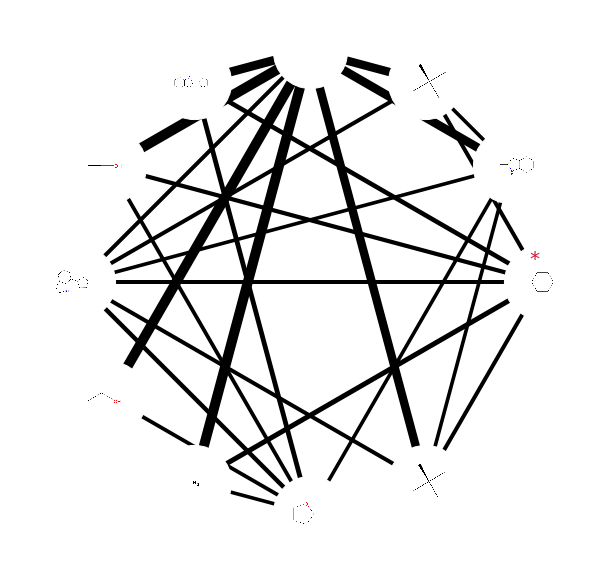

In [11]:
sij = matrix(sij)

dG0 = np.array([-9.9,  np.nan,  np.nan,  np.nan,  np.nan,  np.nan,  np.nan,  np.nan, np.nan, np.nan, np.nan])
delta = np.array([2, np.inf, np.inf, 1, np.inf, np.inf, 3, np.inf, np.inf, 2.5, np.inf])

# make an array describing which nodes should be set as experimental (* tag):
exp_index = []
for val in dG0:
    if np.isnan(val):
        exp_index.append(False)
    else:
        exp_index.append(True)
        
N=1000
integer_n=True

n = networkBFEalloc( sij, N, delta*20)
if integer_n:
    nint = round_to_integers( n)
    n = matrix( nint[:], n.size, tc='d')
    
G = gph.diffnet_to_graph( n)
fig, ax = plt.subplots( figsize=(10, 10))
draw_diffnet_graph( G, lig_images_dict, ligand_order, exp_index,
                   pos="custom", ax=ax, fig=fig, widthscale=200./N, 
                   nodescale=500, molscale=0.05, node_color="white", max_sampling=600)
ax.set_aspect( 1)
ax.axis( 'off')

plt.savefig("TESTSETS/loeffler18/diff_network.png", dpi=300)
plt.show()
